In [1]:
import yt
import numpy as np
from scipy import *
import yt.units as u

In [2]:
%matplotlib inline
import pylab as plt

In [4]:
my_header =  ['raw_density', 'x-velocity','y-velocity','z-velocity', 'raw_pressure_nt',
                  'raw_pressure','metal','ref','H','E','H+','HE','HE+','HE++','H-','H2','H2+']
def density_alias(field, data):
    return data.ds.arr(data['raw_density'], 'code_mass/code_length**3')
def pressure_alias(field, data):
    return data.ds.arr(data['raw_pressure'], 'code_mass/code_time**2/code_length')
def pressure_nt_alias(field, data):
    return data.ds.arr(data['raw_pressure_nt'], 'code_mass/code_time**2/code_length')
def metallicity_alias(field, data):
    return data.ds.arr(data['metal'])
def temp(field,data):
    return data.ds.arr(data['pressure']/data['density']/u.boltzmann_constant, 'code_temperature')

In [5]:
ds = yt.load("output_00028/info_00028.txt",fields=my_header)

yt : [INFO     ] 2018-07-31 10:55:04,005 Parameters: current_time              = 3.17276944493
yt : [INFO     ] 2018-07-31 10:55:04,006 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-07-31 10:55:04,007 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-07-31 10:55:04,008 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-07-31 10:55:04,010 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-07-31 10:55:04,011 Parameters: current_redshift          = 5.99989573952965
yt : [INFO     ] 2018-07-31 10:55:04,012 Parameters: omega_lambda              = 0.691999971866608
yt : [INFO     ] 2018-07-31 10:55:04,013 Parameters: omega_matter              = 0.30799999833107
yt : [INFO     ] 2018-07-31 10:55:04,014 Parameters: hubble_constant           = 0.677900009155273


In [6]:
ds.add_field(('gas','density'), function=density_alias, units='g/cm**3',
             sampling_type='cell',force_override=True)
ds.add_field('pressure', function=pressure_alias, units='g/cm/s**2',
             sampling_type='cell',force_override=True)
ds.add_field('pressure_nt', function=pressure_nt_alias, units='g/cm/s**2',
             sampling_type='cell',force_override=True)
ds.add_field(('gas','metallicity'), function=metallicity_alias,
             sampling_type='cell',force_override=True)
ds.add_field(('gas','temperature'), function=temp,units='K',
             sampling_type='cell',force_override=True)

In [7]:
# galaxy position
center_init = [ 0.53095117,  0.51029149,  0.50401411]
los_vec = [ 0.9,    0.3082207, 0.3082207]
mms = 512
size = 0.00166389148881
size_kpc = 7.0
up_vec = [ 0.3082207,  0.9, 0.3082207]

In [9]:
# Thomson scattering cross section
sigma_t = yt.YTQuantity(6.6524e-25,'cm**2')

In [10]:
# random sampling of ray direction
num_rays = 1
rtheta = np.arccos(1-2*np.random.rand(num_rays))
rphi = np.random.rand(num_rays)*2*pi

In [11]:
# radius of the ray path
radius = 4*u.kpc
r_norm = np.array(radius/ds.domain_width.in_units('kpc')[0])

In [12]:
# loop to sample light rays
tau = []
dcol = []
for i in range(num_rays):
    theta = rtheta[i]
    phi = rphi[i]
    endpos = center_init + r_norm*[sin(theta)*cos(phi), sin(theta)*sin(phi), cos(phi)]
    ray = ds.ray(center_init, endpos)
    a=ray['t']
    dens_col=np.sum(ray['density']*ray['dts'])/u.mass_hydrogen * radius
    tau.append(dens_col*sigma_t)
    dcol.append(dens_col)
    #print(col_dens.in_cgs())
tau = yt.YTArray(tau)
dcol = yt.YTArray(dcol)

In [13]:
dcol.in_cgs()

YTArray([  4.66824347e+23]) cm**(-2)

yt : [INFO     ] 2018-07-31 10:55:59,187 Projection completed
yt : [INFO     ] 2018-07-31 10:55:59,189 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-07-31 10:55:59,190 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-07-31 10:55:59,192 xlim = 0.010291 1.010291
yt : [INFO     ] 2018-07-31 10:55:59,193 ylim = 0.004014 1.004014
yt : [INFO     ] 2018-07-31 10:55:59,197 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2018-07-31 10:56:00,102 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



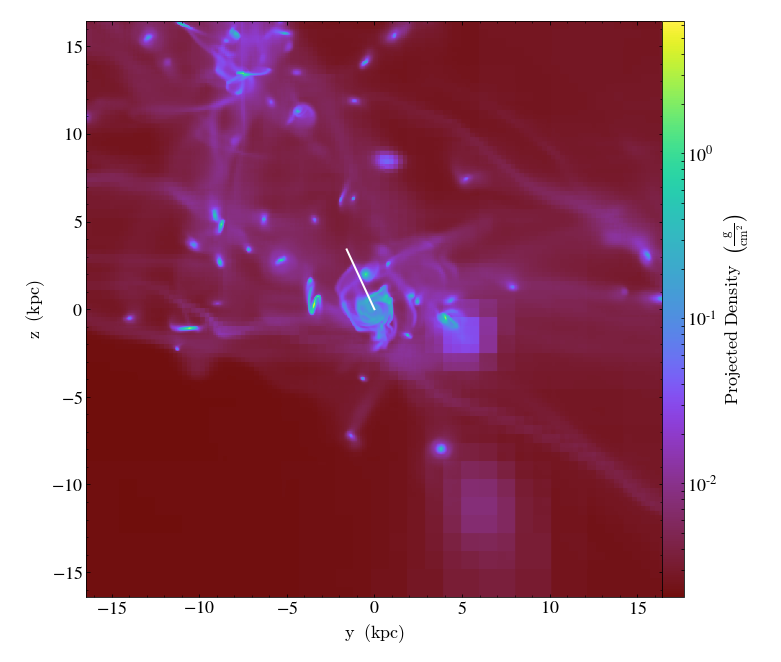

In [14]:
p = yt.ProjectionPlot(ds,'x','density',center_init)
#p = yt.SlicePlot(ds, 'y', 'density',center_init)
p.annotate_ray(ray)
p.zoom(128)

In [48]:
# column density distribution
p,bins = np.histogram(log10(dcol.in_cgs()),bins=20)
bin_center = (bins[:-1]+bins[1:])/2.

Text(0,0.5,'count')

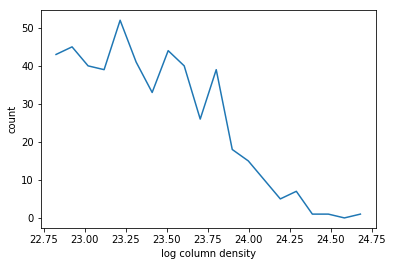

In [49]:
plt.plot(bin_center,p)
plt.xlabel(r'log column density')
plt.ylabel('count')

In [15]:
# load CLOUDY data
ion_c = np.load("./ion_column_density_grid/ion_column.npy")
hden = np.load("./ion_column_density_grid/hdens_list.npy")
rad = np.load("./ion_column_density_grid/intensity_list.npy")+1.8
metal = np.load("./ion_column_density_grid/Z_list.npy")
nh = np.load("./ion_column_density_grid/NH_list.npy")
ion = np.load("./ion_column_density_grid/ion_list.npy")

In [16]:
print(ion)

[b'C' b'C+' b'C+2' b'O' b'O+' b'O+2']


In [17]:
print(ion_c.shape)
print(hden.shape)
print(metal.shape)
print(ion.shape)
print(nh.shape)
print(rad.shape)

(12, 12, 8, 30, 6)
(12,)
(8,)
(6,)
(30,)
(12,)


In [18]:
# select data for ions
ion_cc = ion_c[:,8,:,:,1]

In [28]:
# get index for the left edge value
def ind_hden(x):
    if x>4.5:
        return "hden out of interpolation range"
    return int(2*(x+1))

def ind_z(x):
    if x>0.5:
        return "metal out of interpolation range"
    return int((x+3)*7./3.5)

def ind_nh(x):
    if x>23:
        return "colum density out of interpolation range"
    return int((x-15)*29./8.)

# trilinear interpolation
def col_cc(x,y,z):
    x = min(max(log10(x),-1),4.5)
    y = min(max(log10(y),-3),0.5)
    z = min(max(log10(z),15),22.9)
    
    ix = ind_hden(x)
    iy = ind_z(y)
    iz = ind_nh(z)
    xd = (x-hden[ix])/(hden[ix+1]-hden[ix])
    yd = (y-metal[iy])/(metal[iy+1]-metal[iy])
    zd = (z-nh[iz])/(nh[iz+1]-nh[iz])

    # x-axis
    c000 = ion_cc[ix,iy,iz]
    c100 = ion_cc[ix+1,iy,iz]
    c00 = c000*(1-xd) + c100*xd
    
    c001 = ion_cc[ix,iy,iz+1]
    c101 = ion_cc[ix+1,iy,iz+1]
    c01 = c001*(1-xd) + c101*xd
    
    c010 = ion_cc[ix,iy+1,iz]
    c110 = ion_cc[ix+1,iy+1,iz]
    c10 = c010*(1-xd) + c110*xd
    
    c011 = ion_cc[ix,iy+1,iz+1]
    c111 = ion_cc[ix+1,iy+1,iz+1]
    c11 = c011*(1-xd) + c111*xd

    # y-axis
    c0 = c00*(1-yd) + c10*yd
    c1 = c01*(1-yd) + c11*yd
    
    # z-axis
    c = c0*(1-zd) + c1*zd
    
    return c

col_cc = np.vectorize(col_cc)

In [180]:
# variables along the ray
# number density
var1 = (ray['density']/u.mass_hydrogen).in_cgs().value
# solar metallicity
var2 = ray['metallicity'].value/0.02
# total column density
var3 = (var1*ray['dts']*radius.in_cgs()).value

In [31]:
# elementwise column density
densc = col_cc(var1,var2,var3)

In [32]:
# pallel velocity
v_par = (ray['x-velocity']*sin(theta)*cos(phi) + ray['y-velocity']*sin(theta)*sin(phi) + ray['z-velocity']*cos(phi))/u.c
# random component
sig = (ray['pressure']+ray['pressure_nt'])/ray['density']/u.c**2

In [175]:
# center value of frequency
nu0 = ((u.c/(1334.5323*u.angstrom)).in_cgs()).value

In [203]:
# creat wavelength and frequency bins
lamb = np.linspace(1330,1340,200)
nu = ((u.c/(lamb*u.angstrom)).in_cgs()).value

In [204]:
# oscillatory strength
f = 0.1278
# convert to cross section
sigma = f*pi*u.elementary_charge**2/u.electron_mass/(nu0*u.hertz)/u.c
sigma = (sigma.in_cgs()).value

In [205]:
# sum the optical depth
tau = np.array([sum(densc*sigma*exp(-(nu[i]-nu0*(1+v_par))**2/(nu0**2*sig))) for i in range(200)])

Text(0,0.5,'$\\exp(-\\tau)$')

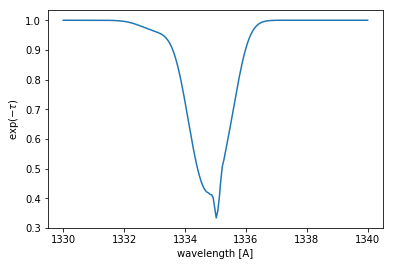

In [213]:
plt.plot(lamb,exp(-tau))
plt.xlabel("wavelength [A]")
plt.ylabel(r"$\exp(-\tau)$")

In [209]:
abs(v_par)

YTArray([  2.36876837e-04,   1.69872574e-04,   2.10290349e-06,
         8.18320853e-05,   5.38044814e-05,   2.03034493e-04,
         2.32474827e-04,   2.38979704e-04,   1.53292310e-04,
         1.50064332e-04,   1.33557326e-04,   1.35692272e-04,
         1.40390080e-04,   1.36074263e-04,   1.50227159e-04,
         1.40222645e-04,   1.12761297e-04,   9.72581949e-05,
         8.19110348e-05,   4.81575291e-05,   8.59711294e-05,
         1.19804092e-04,   4.69331997e-05,   3.95281251e-04,
         2.89696928e-04,   3.68936321e-04,   2.14728051e-04,
         1.99796634e-04,   3.90447449e-04,   3.95916603e-04,
         3.65625754e-04,   2.76763903e-04,   2.74973383e-04,
         2.75046049e-04,   2.27564856e-04,   2.04444847e-04,
         1.47864384e-04,   6.91377846e-05,   9.89390932e-05,
         2.04021537e-05,   1.47259847e-04,   8.00265216e-04,
         7.68104672e-04,   7.45940849e-04,   7.14704135e-04,
         6.96348573e-04,   6.59640340e-04,   6.79522619e-04,
         6.31011482e-0